# Denoising Diffusion Probabilistic Models with miniai

## Imports

I actually switched to a mini version of miniai that Johno Whitaker put together: https://github.com/johnowhitaker/miniminiai
> It is just a simpler substed of code from Jeremy's `miniai`, basically everythin in a single file

In [1]:
!pip install miniminiai wandb diffusers

  Cloning https://github.com/tcapelle/torch_moving_mnist to /tmp/pip-req-build-p9yl431d
  Running command git clone --filter=blob:none --quiet https://github.com/tcapelle/torch_moving_mnist /tmp/pip-req-build-p9yl431d
  Resolved https://github.com/tcapelle/torch_moving_mnist to commit 415bf153c4ef25cc29b497e134197c7cc36c367d
  Preparing metadata (setup.py) ... done
  Created wheel for torch-moving-mnist: filename=torch_moving_mnist-0.0.2-py3-none-any.whl size=12399 sha256=9904bf6e05ccd7863fd857a030df79bfe998dabf94d68c277e089a25eaa7a72f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ufxu9obg/wheels/02/3b/60/9840309b2405ffc0bd54541027f54fd2afb1af54f0a217acfa
Successfully built torch-moving-mnist
  Attempting uninstall: torch-moving-mnist
    Found existing installation: torch-moving-mnist 0.0.2
    Uninstalling torch-moving-mnist-0.0.2:
      Successfully uninstalled torch-moving-mnist-0.0.2


In [2]:
import logging
from pathlib import Path
from functools import partial
from types import SimpleNamespace

from fastprogress import progress_bar
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt

import wandb

import torch
from torch import optim, nn
from torch.nn import init
from torch.utils.data import DataLoader, default_collate
from diffusers import UNet2DModel, DDIMScheduler

from miniminiai import DataLoaders, show_images, Learner, AccelerateCB, ProgressCB, MetricsCB, BatchSchedCB, Callback

In [3]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

## Load the dataset

In [4]:
config = SimpleNamespace(    
    epochs = 15,
    model_name="ddpm_mmnist_miniai",
    noise_steps=1000,
    seed = 42,
    batch_size = 128,
    img_size = 40,
    device = "cuda",
    use_wandb = True,
    num_workers=8,
    num_frames=3,
    lr = 1e-3)

# DATASET_AT = 'miniai_ddpm/MMNIST40_128k:latest'
DATASET_AT = 'miniai_ddpm/MMNIST40_20k:latest'

Let's grab a precomputed MMNIST dataset from a W&B artifact

In [5]:
api = wandb.Api()
dataset = api.artifact(DATASET_AT)
dataset_folder = Path(dataset.download())

wandb: Downloading large artifact MMNIST40_20k:latest, 488.28MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


In [6]:
ds = torch.load(next(dataset_folder.glob("*.pt"))) - 0.5
# ds = ds[0:3000] # to debug your code

In [7]:
ds.device, ds.shape

(device(type='cpu'), torch.Size([20000, 4, 1, 40, 40]))

In [8]:
split_val = int(0.9*len(ds))
train_ds = ds[:split_val].squeeze()
valid_ds = ds[split_val:].squeeze()

Let's look at the data:

In [9]:
xb = train_ds[:4]

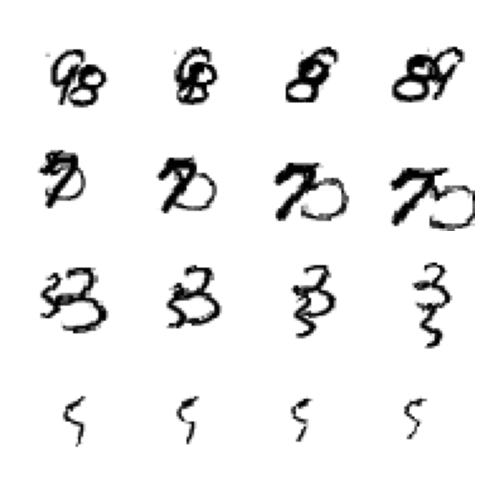

In [10]:
show_images(xb.reshape(-1, 1, config.img_size, config.img_size), imsize=1.5)

We will use the same noisify function as the one from the fastai course

In [11]:
betamin,betamax,n_steps = 0.0001,0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

def noisify_ddpm(x0):
    "Noise by ddpm"
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

We wrap the noisify func and apply it to the last frame of the sequence. We refactor this in the `NoisifyDataloader`

In [12]:
def noisify_last_frame(frames, noise_func):
    "Noisify the last frame of a sequence"
    past_frames = frames[:,:-1]
    last_frame  = frames[:,-1:]
    noise, t, e = noise_func(last_frame)
    return torch.cat([past_frames, noise], dim=1), t, e

def noisify_collate(noise_func): 
    def _inner(b): 
        "Collate function that noisifies the last frame"
        return noisify_last_frame(default_collate(b), noise_func)
    return _inner

class NoisifyDataloader(DataLoader):
    """Noisify the last frame of a dataloader by applying 
    a noise function, after collating the batch"""
    def __init__(self, dataset, *args, noise_func=noisify_ddpm, **kwargs):
        super().__init__(dataset, *args, collate_fn=noisify_collate(noise_func), **kwargs)

In [13]:
xt, t, ε = noisify_last_frame(xb[:4], noisify_ddpm)
t

tensor([761, 858, 338, 333])

In [14]:
xt.shape

torch.Size([4, 4, 40, 40])

Let's show the noisy last frame with the noise level as title

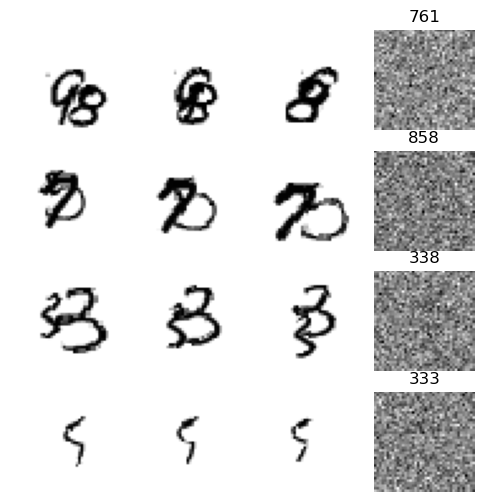

In [15]:
titles = fc.map_ex(t, '{}')
titles = fc.concat(zip([[None,None,None]]*len(titles), titles)) 
show_images(xt.reshape(-1, 1, config.img_size, config.img_size), imsize=1.5, titles=titles)

## Training

A better init for the UNet

In [18]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

Create the noisified DataLoader

In [20]:
dls = DataLoaders(NoisifyDataloader(train_ds, config.batch_size, num_workers=config.num_workers, pin_memory=True, shuffle=True), 
                  NoisifyDataloader(valid_ds, config.batch_size, num_workers=config.num_workers, shuffle=False))

Standard DDIM sampler from Diffuser wrapped to use the last frame

In [22]:
@torch.no_grad()
def diffusers_sampler(model, past_frames, sched, **kwargs):
    "Using Diffusers built-in samplers"
    model.eval()
    device = next(model.parameters()).device
    past_frames = past_frames.to(device)
    new_frame = torch.randn_like(past_frames[:,-1:], dtype=past_frames.dtype, device=device)
    preds = []
    pbar = progress_bar(sched.timesteps, leave=False)
    for t in pbar:
        pbar.comment = f"DDIM Sampler: frame {t}"
        noise = model(torch.cat([past_frames, new_frame], dim=1), t).sample
        new_frame = sched.step(noise, t, new_frame, **kwargs).prev_sample
        preds.append(new_frame.float().cpu())
    return preds[-1]

def ddim_sampler(steps=350, eta=1.):
    "DDIM sampler, faster and a bit better than the built-in sampler"
    ddim_sched = DDIMScheduler()
    ddim_sched.set_timesteps(steps)
    return partial(diffusers_sampler, sched=ddim_sched, eta=eta)

A simple WandbCB for `miniminiai`

In [24]:
class WandbCB(Callback):
    "Hacky W&B callback"
    order = MetricsCB.order+1
    def __init__(self, model_name=None): self.model_name = model_name
    def before_fit(self, learn):
        if wandb.run is None:
            raise Exception("You have to run fit inside a wandb run")
        if hasattr(learn, 'metrics'): 
            self._log_copy = learn.metrics._log
            learn.metrics._log = self._log
        self.losses = []

    def _log(self, d):
        self._log_copy(d)
        wandb.log(d)
    
    def after_batch(self, learn):
        if learn.training:
            wandb.log({"train_loss":learn.loss.item()})
                       # "lr":learn.schedo.get_last_lr()[0]})
    def after_fit(self, learn):
        if self.model_name is not None:
            model_name = f"{wandb.run.id}_{self.model_name}"
            at = wandb.Artifact(model_name, type="model")
            torch.save(learn.model.state_dict(), f"models/{self.model_name}.pth")
            at.add_file(f"models/{self.model_name}.pth")
            wandb.log_artifact(at)

In [25]:
def to_wandb_image(img):
    "Stack the images horizontally"
    return wandb.Image(torch.cat(img.split(1), dim=-1).cpu().numpy())

def log_images(model, xt):
    "Sample and log images to W&B"
    samples = ddim_sampler()(model, xt)
    frames = torch.cat([xt.to(samples[-1].device), samples], dim=1)
    wandb.log({"sampled_images": [to_wandb_image(img) for img in frames]})

Let's log some predictions to W&B

In [26]:
class LogPreds(Callback):
    "Log samples to W&B"
    order = WandbCB.order+1
    def __init__(self, n_preds=10, self.log_every=1):
        self.log_every = log_every
        self.n_preds = n_preds
    
    def before_fit(self, learn):
        dt = learn.dls.valid
        xt, t, ε = next(iter(dt))
        self.xt = xt[:self.n_preds,:-1,...]
    
    def after_epoch(self, learn):
        if not learn.training and (learn.epoch%self.log_every==0):
            log_images(learn.model, self.xt)

In [27]:
class DDPMCB(Callback):
    "We need to recover the UNet output from the OutputDict"
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [28]:
tmax = config.epochs * len(dls.train)
sched = partial(optim.lr_scheduler.OneCycleLR, max_lr=config.lr, total_steps=tmax)
opt_func = partial(optim.Adam, eps=1e-5)

In [29]:
model = UNet2DModel(in_channels=4, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(reduction="sum"), lr=config.lr, cbs=cbs, opt_func=opt_func)

In [30]:
{cb.__class__.__name__:cb.order for cb in learn.cbs}

{'DDPMCB': 0,
 'ProgressCB': 1,
 'MetricsCB': 0,
 'BatchSchedCB': 0,
 'AccelerateCB': 10}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


loss,epoch,train
608130.062,0,train
249127.859,0,eval
69375.594,1,train
19252.654,1,eval
17078.279,2,train
15848.737,2,eval
14803.806,3,train
13372.645,3,eval
13205.403,4,train
12180.861,4,eval


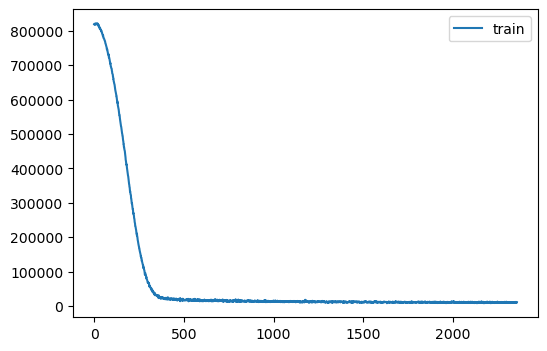

In [ ]:
with wandb.init(project="miniminiai_ddpm", config=config):
    learn.fit(config.epochs, cbs=[WandbCB("test_model"), LogPreds()])